In [1]:
import argparse
import os

import torch
from torchvision.utils import save_image
from tqdm import tqdm

from vqvae import VQVAE
from pixelsnail import PixelSNAIL
import numpy as np
from matplotlib import pyplot as plt

In [2]:
@torch.no_grad()
def sample_model(model, device, batch, size, temperature, condition=None):
    row = torch.zeros(batch, *size, dtype=torch.int64).to(device)
    cache = {}

    for i in tqdm(range(size[0])):
        for j in range(size[1]):
            out, cache = model(row[:, : i + 1, :], condition=condition, cache=cache)
            prob = torch.softmax(out[:, :, i, j] / temperature, 1)
            sample = torch.multinomial(prob, 1).squeeze(-1)
            row[:, i, j] = sample

    return row


def load_model(model, checkpoint, device):

    if model == 'vqvae':
        model = VQVAE()

    elif model == 'pixelsnail_top':
        model = PixelSNAIL(
            [32, 32],
            512,
            channel,
            5,
            4,
            n_res_block,
            n_res_channel,
            dropout=dropout,
            n_out_res_block=n_out_res_block,
        )

    elif model == 'pixelsnail_bottom':
        model = PixelSNAIL(
            [64, 64],
            512,
            channel,
            5,
            4,
            n_res_block,
            n_res_channel,
            attention=False,
            dropout=dropout,
            n_cond_res_block=n_cond_res_block,
            cond_res_channel=n_res_channel,
        )
        
    model.load_state_dict(torch.load(checkpoint),strict=False)
    model = model.to(device)
    model.eval()

    return model

In [13]:
device = 'cuda'
n_res_block=4
n_res_channel=256
n_out_res_block=0
n_cond_res_block=3
channel=256
dropout=0.1

batch=1

vqvae='runs/14.04.2024/vqvae_010_train_0.02093_test_0.02107.pt'
top='runs/14.04.2024/65_pixelsnail_top_train_loss_1.281939_acc_0.379639_test_loss_1.230041_acc_0.391327.pt'
bottom='runs/14.04.2024/32_pixelsnail_bottom_train_loss_1.620844_acc_0.359253_test_loss_1.641029_acc_0.339485.pt'

filename='test.png'
temp=10

model_vqvae = load_model('vqvae', vqvae, device)
model_top = load_model('pixelsnail_top', top, device)
model_bottom = load_model('pixelsnail_bottom', bottom, device)

In [14]:
top_sample = sample_model(model_top, device, batch, [32, 32], temp)
bottom_sample = sample_model(
    model_bottom, device, batch, [64, 64], temp, condition=top_sample
)

decoded_sample = model_vqvae.decode_code(top_sample, bottom_sample)
decoded_sample = decoded_sample.clamp(-1, 1)

# save_image(decoded_sample, filename, normalize=True, range=(-1, 1))

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:14<00:00,  1.17s/it]


In [15]:
img=decoded_sample[0].cpu().detach().numpy()

img=np.swapaxes(img, 0,-1)

In [16]:
img=img+1
img*=255

img=img.astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


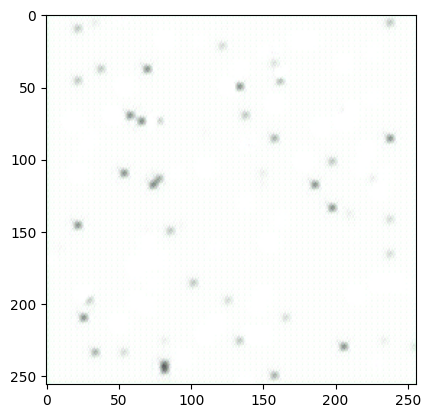

In [19]:
plt.imshow(img, cmap='gray')